In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import time
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import numpy as np
import matplotlib.pyplot as plt
from array2gif import write_gif

from models.vae import VAE

plt.style.use('ggplot')

mnist = input_data.read_data_sets("/tmp/data/", one_hot = True)

C:\Users\wtais\Anaconda3\envs\hackthewind\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


#### Instantiate VAE and Saver

In [2]:
vae = VAE(beta=1,batch_size=1000,learning_rate=1e-4,latent_dim=20)
saver = tf.train.Saver()

#### Training

In [3]:
# Initialization
list_of_latent_spaces = []
list_of_z_mu = []
history_loss = []
history_recon = []
history_kl = []
epoch_loss = 0
recon_loss = 0
kl_loss = 0

hm_epochs = 1000

In [ ]:
for epoch in range(hm_epochs):

    for _ in range(int(mnist.train.num_examples/vae.batch_size)):
        epoch_x, epoch_label = mnist.train.next_batch(vae.batch_size)
        epoch_label = np.argmax(epoch_label,axis=1)
        _, c, recon, kl = vae.fit(np.rint(epoch_x).astype(np.float32))
        epoch_loss += c/(int(mnist.train.num_examples/vae.batch_size) * vae.batch_size)
        recon_loss += recon/(int(mnist.train.num_examples/vae.batch_size) * vae.batch_size)
        kl_loss += kl/(int(mnist.train.num_examples/vae.batch_size) * vae.batch_size)
        history_loss.append(epoch_loss)
        history_recon.append(recon_loss)
        history_kl.append(kl_loss)
        
    if epoch % 10 is 0:
        print('Epoch', epoch+1, '/',hm_epochs,'; average loss:',epoch_loss, end='; ')
        print('Reconstruction loss : ', recon_loss, end='; ')
        print('KL loss', kl_loss)


#### Only use this section if saving model

In [11]:
timestr = time.strftime("%Y%m%d-%H%M%S")
filename = 'saved_models/vae-fc-'
saved_filename = filename+timestr
saver.save(vae.sess,filename+timestr)

'saved_models/vae-fc-20181029-232545'

#### Restoring model weights

In [4]:
saver.restore(vae.sess, 'saved_models/vae-fc-20181029-232545')

INFO:tensorflow:Restoring parameters from saved_models/vae-fc-20181029-232545


#### Visualise data reconstruction

In [11]:
test_epoch, _ = mnist.test.next_batch(vae.batch_size)
x_tst = vae.reconstruct_X(np.rint(test_epoch).astype(np.float32))

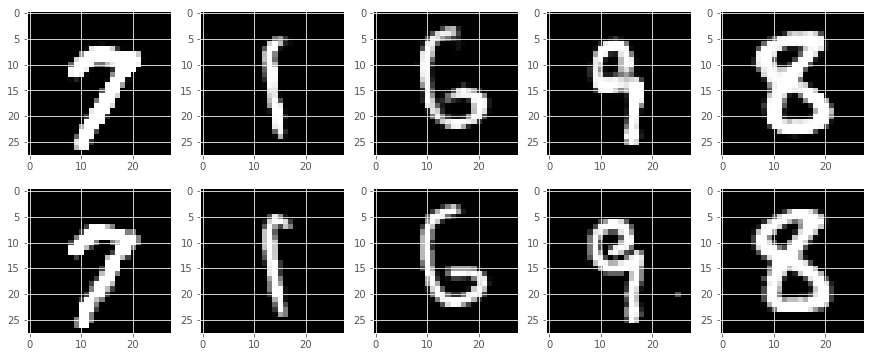

In [12]:
fig, axs = plt.subplots(2,5, figsize=(15, 6))
axs = axs.ravel()
n = 0
j = 0

for i in range(n,n+5):
    axs[j].imshow(x_tst[i,:].reshape([28,28]),cmap='gray')
    axs[j+5].imshow(test_epoch[i,:].reshape([28,28]),cmap='gray')
    j += 1
    
plt.show()

#### Visualise latent space

In [7]:
from sklearn import manifold

In [8]:
def draw_digits_latent_space(z_mean_test, test_label):
    plt.scatter(z_mean_test[:,0],z_mean_test[:,1],c=test_label,cmap=plt.cm.get_cmap('jet', 10))
    plt.colorbar()
    plt.show()

In [9]:
test_x, test_label = mnist.test.next_batch(vae.batch_size)
test_label = np.argmax(test_label,axis=1)
z_mu = vae.get_z_mean(np.rint(test_x).astype(np.float32))
tsne = manifold.TSNE(n_components=2, random_state=42)
z_tsne = tsne.fit_transform(z_mu)


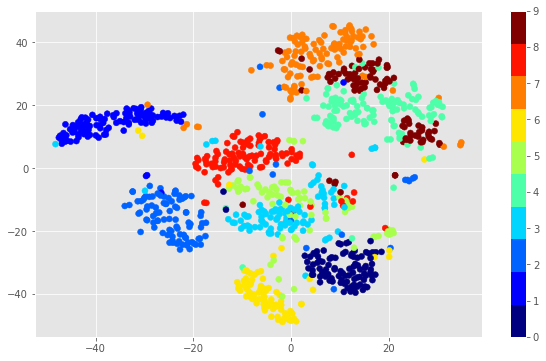

In [10]:
plt.figure(figsize=(10, 6))
draw_digits_latent_space(z_tsne, test_label)
plt.show()

#### Visualize effect of traversing latent space

In [231]:
test_x, test_label = mnist.test.next_batch(vae.batch_size)
z = vae.get_z_mean(test_x)

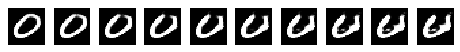

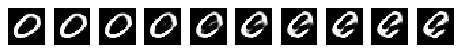

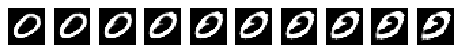

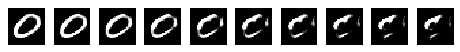

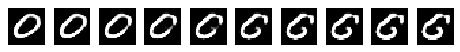

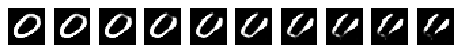

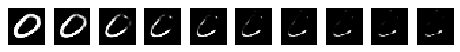

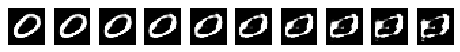

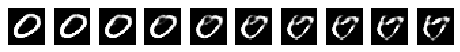

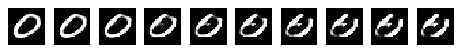

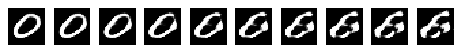

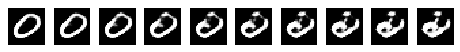

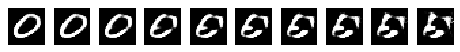

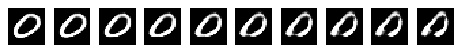

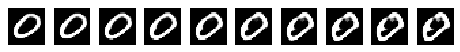

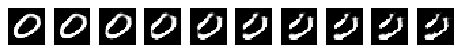

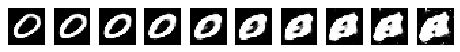

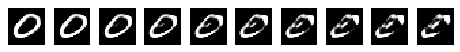

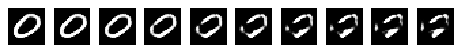

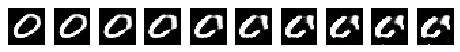

In [232]:
for k in range(0,20):
    z_0 = np.copy(z[0])
    list_of_z = []
    list_of_z.append(z_0)
    dim_observed = k
    z_temp = np.copy(z_0)

    for i in range(0,9):
        z_temp[dim_observed] += 1.5
        list_of_z.append(np.copy(z_temp))
    fig, axs = plt.subplots(1,10, figsize=(8, 2))
    axs = axs.ravel()
    n = 0
    j = 0

    for i in range(0,len(list_of_z)):
        x_gen = vae.generate(np.repeat(list_of_z[i][np.newaxis,:],vae.batch_size,axis=0))
        axs[j].imshow(x_gen[0].reshape([28,28]),cmap='gray')
        axs[j].axes.get_xaxis().set_visible(False)
        axs[j].axes.get_yaxis().set_visible(False)
        j += 1

plt.show()